In [2]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# === Wczytaj dane z CSV ===
X = pd.read_csv("X.csv").values.astype(np.float32)
y = pd.read_csv("y.csv")["default"].values.astype(np.int32)
purpose = pd.read_csv("purpose.csv")["purpose"]

N, K = X.shape

# === Przygotuj dane do model1 (bez efektów losowych) ===
stan_data1 = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist()
}

# === Przygotuj dane do model2 (z efektami losowymi dla 'purpose') ===
le = LabelEncoder()
group_id = le.fit_transform(purpose) + 1  # Stan uses 1-based indexing
G = len(le.classes_)

stan_data2 = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist(),
    "G": G,
    "group_id": group_id.tolist()
}

# === Wczytaj modele Stan ===
model1 = CmdStanModel(stan_file="model1_fit.stan")
model2 = CmdStanModel(stan_file="model2_fit.stan")

# === Fitowanie modeli ===
fit1 = model1.sample(data=stan_data1, chains=4, iter_warmup=1000, iter_sampling=1000, seed=42)
fit2 = model2.sample(data=stan_data2, chains=4, iter_warmup=1000, iter_sampling=1000, seed=42)

# === Konwersja wyników do formatu ArviZ ===
idata1 = az.from_cmdstanpy(posterior=fit1)
idata2 = az.from_cmdstanpy(posterior=fit2)

11:32:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:09 - cmdstanpy - INFO - CmdStan done processing.


11:32:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:52 - cmdstanpy - INFO - CmdStan done processing.
11:32:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_fit.stan', line 19, column 2 to column 46)
Consider re-running with show_console=True if the above output is unclear!
11:32:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 divergent transitions (2.0%)
	Chain 2 had 133 divergent transitions (13.3%)
	Chain 3 had 63 divergent transitions (6.3%)
	Chain 4 had 287 divergent transitions (28.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


📊 WAIC comparison:
         rank   elpd_waic     p_waic  elpd_diff    weight         se  \
Model 1     0 -632.783971  18.112566   0.000000  0.786076  12.009878   
Model 2     1 -634.128366  19.706319   1.344394  0.213924  11.976451   

              dse  warning scale  
Model 1  0.000000    False   log  
Model 2  0.449761     True   log  


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


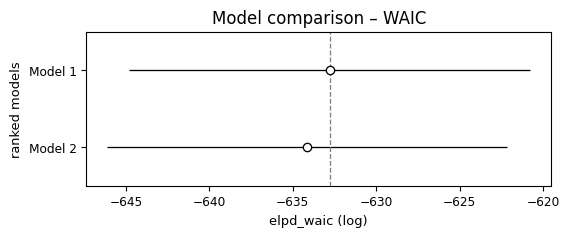

In [3]:
# === Porównanie modeli – WAIC ===
waic_comparison = az.compare(
    {"Model 1": idata1, "Model 2": idata2},
    ic="waic",
    method="BB-pseudo-BMA"
)
print("📊 WAIC comparison:")
print(waic_comparison)
az.plot_compare(waic_comparison)
plt.title("Model comparison – WAIC")
plt.show()


📊 PSIS-LOO comparison:
         rank    elpd_loo      p_loo  elpd_diff    weight         se  \
Model 1     0 -632.921473  18.250068   0.000000  0.786373  11.914124   
Model 2     1 -634.288929  19.866882   1.367456  0.213627  11.899827   

              dse  warning scale  
Model 1  0.000000    False   log  
Model 2  0.453804     True   log  


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


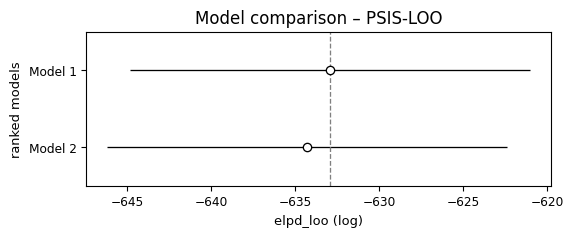

In [4]:
# === Porównanie modeli – PSIS-LOO ===
loo_comparison = az.compare(
    {"Model 1": idata1, "Model 2": idata2},
    ic="loo",
    method="BB-pseudo-BMA"
)
print("📊 PSIS-LOO comparison:")
print(loo_comparison)
az.plot_compare(loo_comparison)
plt.title("Model comparison – PSIS-LOO")
plt.show()

## Model Comparison – Conclusions

Based on the model comparison using WAIC and PSIS-LOO, the following conclusions can be drawn:

1. **Model 1 slightly outperforms Model 2**:
   - Both WAIC and PSIS-LOO assign a higher expected log predictive density (ELPD) to Model 1, indicating better out-of-sample predictive performance.
   - However, the differences in `elpd_diff` between the models (~1.3) are small and within the margin of error (`se ≈ 12`), suggesting that the models perform similarly from a statistical standpoint.

2. **Model 1 has a higher model weight**:
   - Under Bayesian bootstrap-based model averaging (`BB-pseudo-BMA`), Model 1 receives approximately 79% weight, compared to 21% for Model 2. This supports Model 1 as the more probable best model in this context.

3. **Model 2 shows warning signs in both criteria**:
   - WAIC produces a warning indicating that posterior variance in log-likelihood may be too high for some samples, which can undermine reliability of the estimate.
   - PSIS-LOO raises a warning related to the Pareto `k` shape parameter exceeding 0.7 for some observations, suggesting that some data points may have a disproportionate influence and that Model 2 may be less robust.

4. **Interpretation and practical trade-off**:
   - Although Model 2 includes more complexity (via group-level intercepts for `purpose`), this flexibility does not yield a clear predictive benefit over the simpler Model 1.
   - Given its simplicity, interpretability, and better stability, Model 1 is preferred for this dataset.

**Conclusion:**  
Model 1 appears to be the better choice, offering strong predictive performance with fewer parameters and no observed reliability warnings. Model 2 could be reconsidered in scenarios with more group-level variation or when deeper interpretability of subgroup behavior is required.
